In [1]:
import keras , os 
from keras.models import Sequential 
from keras.layers import Dense , Conv2D , MaxPool2D , Flatten 
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import io 
from six import BytesIO
from PIL import Image , ImageDraw , ImageFont 
import tensorflow as tf
from keras import preprocessing 
from tensorflow.keras import layers
from tensorflow.keras import models
import keras, os 
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import io 
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont 
import tensorflow as tf
from keras import preprocessing 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "IMG_CLASSES",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10203 files belonging to 5 classes.


In [4]:
class_names=dataset.class_names
class_names

['1. Eczema',
 '2. Melanoma',
 '4. Basal Cell Carcinoma (BCC)',
 '5. Melanocytic Nevi (NV)',
 '7. Psoriasis pictures Lichen Planus and related diseases']

In [5]:
len(dataset)

319

In [6]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 1 3 1 4 4 0 4 1 0 1 3 1 3 0 4 1 3 1 3 2 2 1 3 2 1 3 1 1 1 4 0]


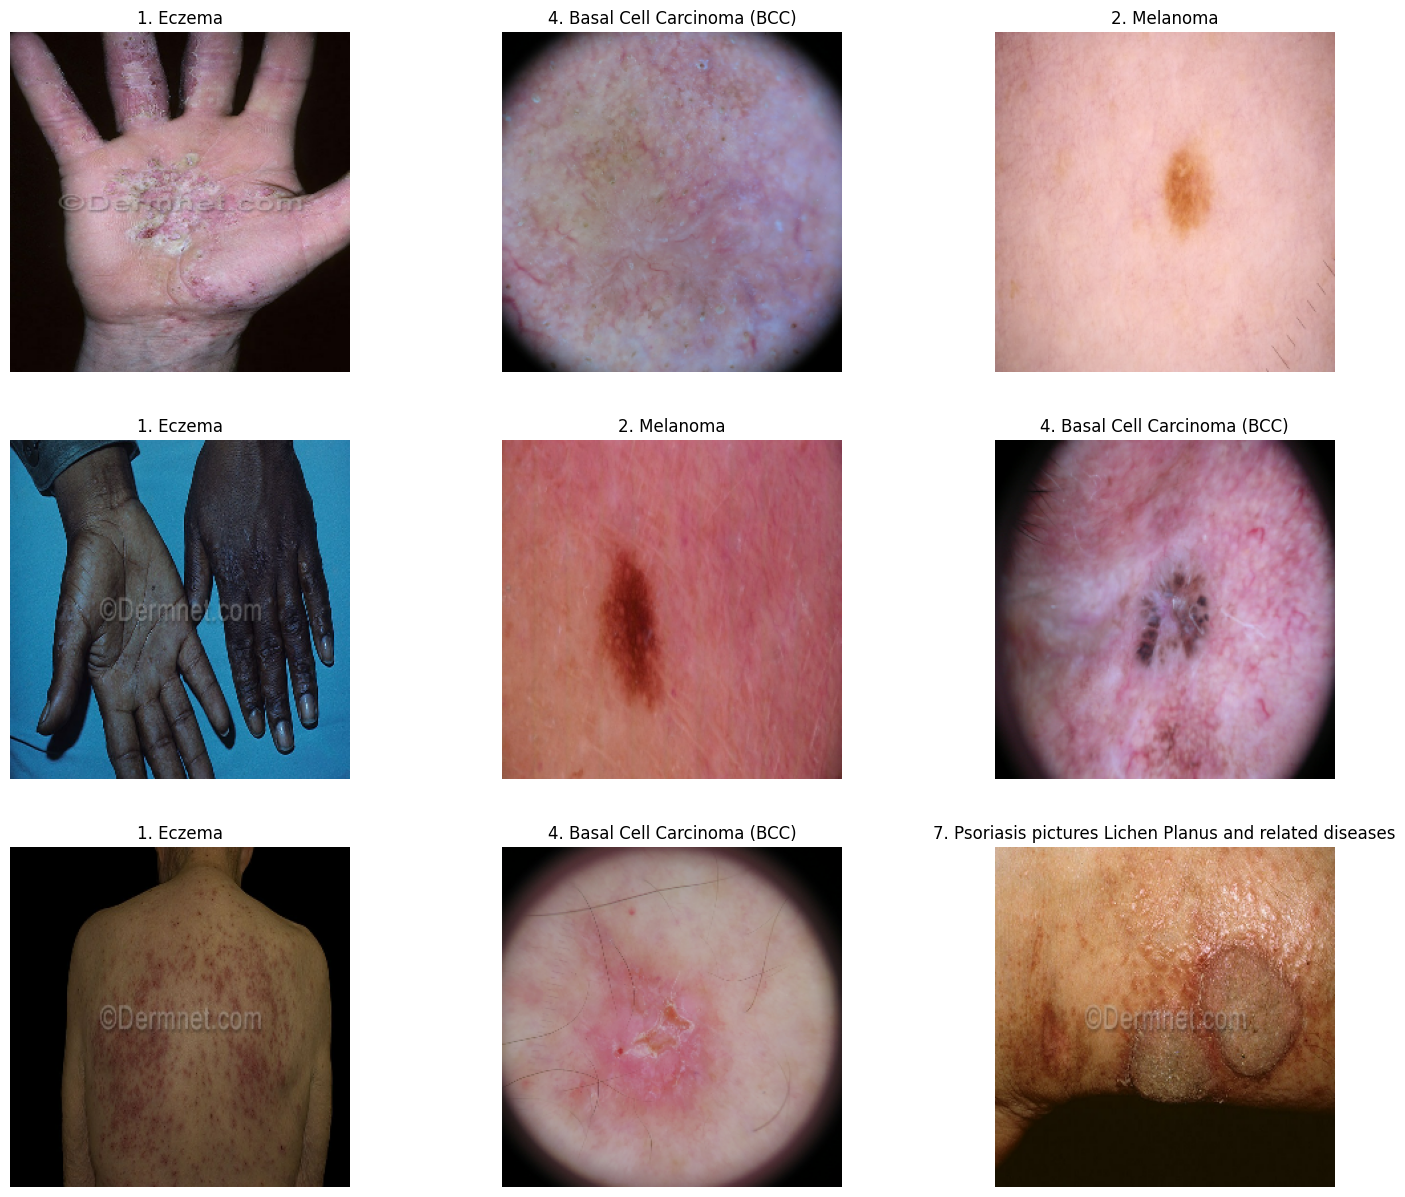

In [8]:
plt.figure(figsize=(18,15))
for image_batch , label_batch in dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        # print(image_batch[0].shape)
        plt.axis("off")

In [11]:
train_size=0.7
len(dataset)*train_size

223.29999999999998

In [12]:
dataset.take(396)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
train_ds=dataset.take(396)
len(train_ds)

319

In [14]:
test_ds=dataset.skip(396)
len(test_ds)

0

In [15]:
val_size=0.1
len(dataset)*val_size

31.900000000000002

In [16]:
val_ds=test_ds.take(56)
len(val_ds)

0

In [17]:
test_ds=test_ds.skip(56)
len(test_ds)

0

In [18]:
def get_dataset_partitions_tf(ds,train_split=0.7 , test_split=0.2 , val_split=0.1, shuffle=True , shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size , seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds ,val_ds ,  test_ds 

In [19]:
train_ds , val_ds , test_ds =get_dataset_partitions_tf(dataset)

In [20]:
print(len(train_ds),len(val_ds),len(val_ds))

223 31 31


In [21]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [23]:
data_augmentation=tf.keras.Sequential([
     tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(0.2),
])

In [24]:
input_shape=(BATCH_SIZE , IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=5

In [25]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
NUM_CLASSES = 5  # Adjust this based on your dataset

# Assuming you have already loaded and preprocessed your dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "IMG_CLASSES",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Function to normalize and augment data
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Prepare datasets
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build VGG16 model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

def build_vgg16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), num_classes=NUM_CLASSES):
    base_model = VGG16(weights=None, include_top=False, input_tensor=Input(shape=input_shape))
    weights_path = 'C:\model.h5'
    base_model.load_weights(weights_path)

    # Freeze the convolutional base
    base_model.trainable = False

    # Create new model on top
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model = build_vgg16()


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

# Evaluate the model on test data



Found 10203 files belonging to 5 classes.
Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 924s 4s/step - accuracy: 0.3986 - loss: 1.3102 - val_accuracy: 0.5988 - val_loss: 0.9110
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 719s 3s/step - accuracy: 0.5577 - loss: 0.9257 - val_accuracy: 0.6341 - val_loss: 0.8289
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 603s 3s/step - accuracy: 0.6075 - loss: 0.8609 - val_accuracy: 0.6260 - val_loss: 0.7653
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 593s 3s/step - accuracy: 0.6156 - loss: 0.8184 - val_accuracy: 0.6935 - val_loss: 0.7293
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 596s 3s/step - accuracy: 0.6234 - loss: 0.8152 - val_accuracy: 0.6935 - val_loss: 0.7161
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 595s 3s/step - accuracy: 0.6386 - loss: 0.7768 - val_accuracy: 0.6744 - val_loss: 0.7131
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 591s 3s/step - accuracy: 0.6600 - loss: 0.7515 - val_accuracy: 0.6991 - val_loss: 0.6739
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 595s 3s/step - 

In [26]:
scores=model.evaluate(test_ds)

65/65 ━━━━━━━━━━━━━━━━━━━━ 777s 11s/step - accuracy: 0.7738 - loss: 0.5139


In [27]:
scores

[0.5285232067108154, 0.7658653855323792]

In [28]:
history

In [29]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 223}

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
history.history['accuracy']

[0.46473145484924316,
 0.5669611692428589,
 0.6069226264953613,
 0.6184265613555908,
 0.632707417011261,
 0.6436378955841064,
 0.6555882692337036,
 0.6583929061889648,
 0.6755013465881348,
 0.6848969459533691,
 0.683576226234436,
 0.6904428005218506,
 0.691908597946167,
 0.6920487880706787,
 0.698991060256958,
 0.6993408799171448,
 0.7020739912986755,
 0.7013041377067566,
 0.7065582871437073,
 0.7060720920562744,
 0.7077548503875732,
 0.7221988439559937,
 0.7090169787406921,
 0.7104192972183228,
 0.7158883810043335,
 0.7116813659667969,
 0.7181320786476135,
 0.7184697389602661,
 0.7185527682304382,
 0.7193942070007324,
 0.7223390936851501,
 0.7308015823364258,
 0.7289299964904785,
 0.7271069884300232,
 0.7301921248435974,
 0.7327163219451904,
 0.7292104959487915,
 0.7380451560020447,
 0.7324832081794739,
 0.7371076345443726,
 0.7348198294639587,
 0.7387463450431824,
 0.7407096028327942,
 0.7326233386993408,
 0.7425326108932495,
 0.7468798160552979,
 0.7354260087013245,
 0.7355661392211

In [32]:
len(history.history['accuracy'])

50

In [33]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']


loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

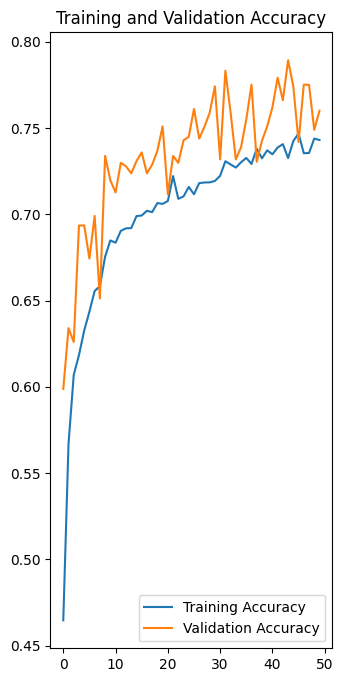

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


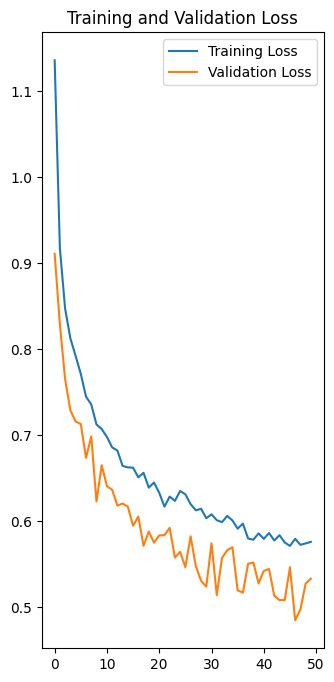

In [36]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()

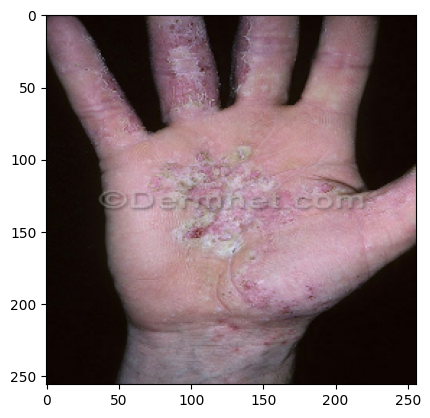

In [37]:
for images_batch , labels_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))

[[[195 150 155]
  [192 147 152]
  [194 151 158]
  ...
  [191 148 157]
  [199 156 165]
  [200 157 166]]

 [[195 150 157]
  [190 145 152]
  [196 153 160]
  ...
  [195 152 161]
  [200 157 166]
  [201 158 167]]

 [[196 150 160]
  [183 140 149]
  [195 152 161]
  ...
  [200 158 168]
  [196 154 164]
  [196 154 164]]

 ...

 [[178 144 160]
  [179 147 162]
  [181 148 165]
  ...
  [194 158 168]
  [188 152 162]
  [178 142 152]]

 [[178 144 160]
  [178 144 160]
  [176 142 158]
  ...
  [194 158 168]
  [190 154 164]
  [189 153 165]]

 [[174 140 156]
  [175 141 157]
  [174 140 156]
  ...
  [194 158 170]
  [189 153 165]
  [189 153 165]]]


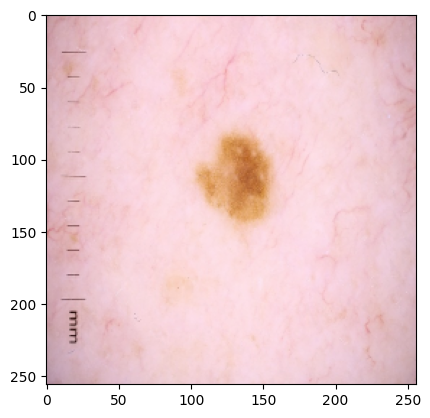

In [49]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming `test_ds` is your dataset and images are normalized to [0, 1]
for images_batch, labels_batch in test_ds.take(1):
    # Convert the first image in the batch to uint8
    image = (images_batch[0].numpy() * 255).astype('uint8')
    print(image)
    plt.imshow(image)
    plt.show()

first image to predict
first image's actual label: 1. Eczema
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
predicted label  7. Psoriasis pictures Lichen Planus and related diseases


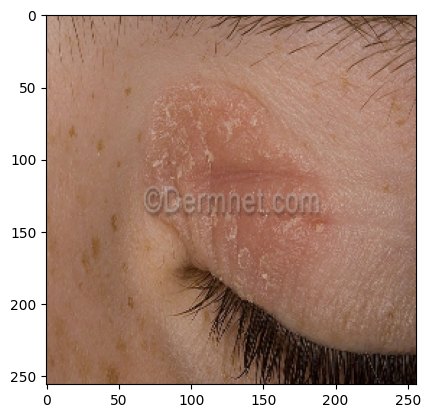

In [51]:
for images_batch , labels_batch in test_ds.take(1):
    first_image=(images_batch[0].numpy()*255).astype('uint8')
    first_label=labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:" , class_names[first_label])

    batch_prediction=model.predict(images_batch)
    print("predicted label " , class_names[np.argmax(batch_prediction[0])])
    

In [52]:
def prediction(model,img):
    img_array_1=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array_1,0)


    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]


    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence 
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


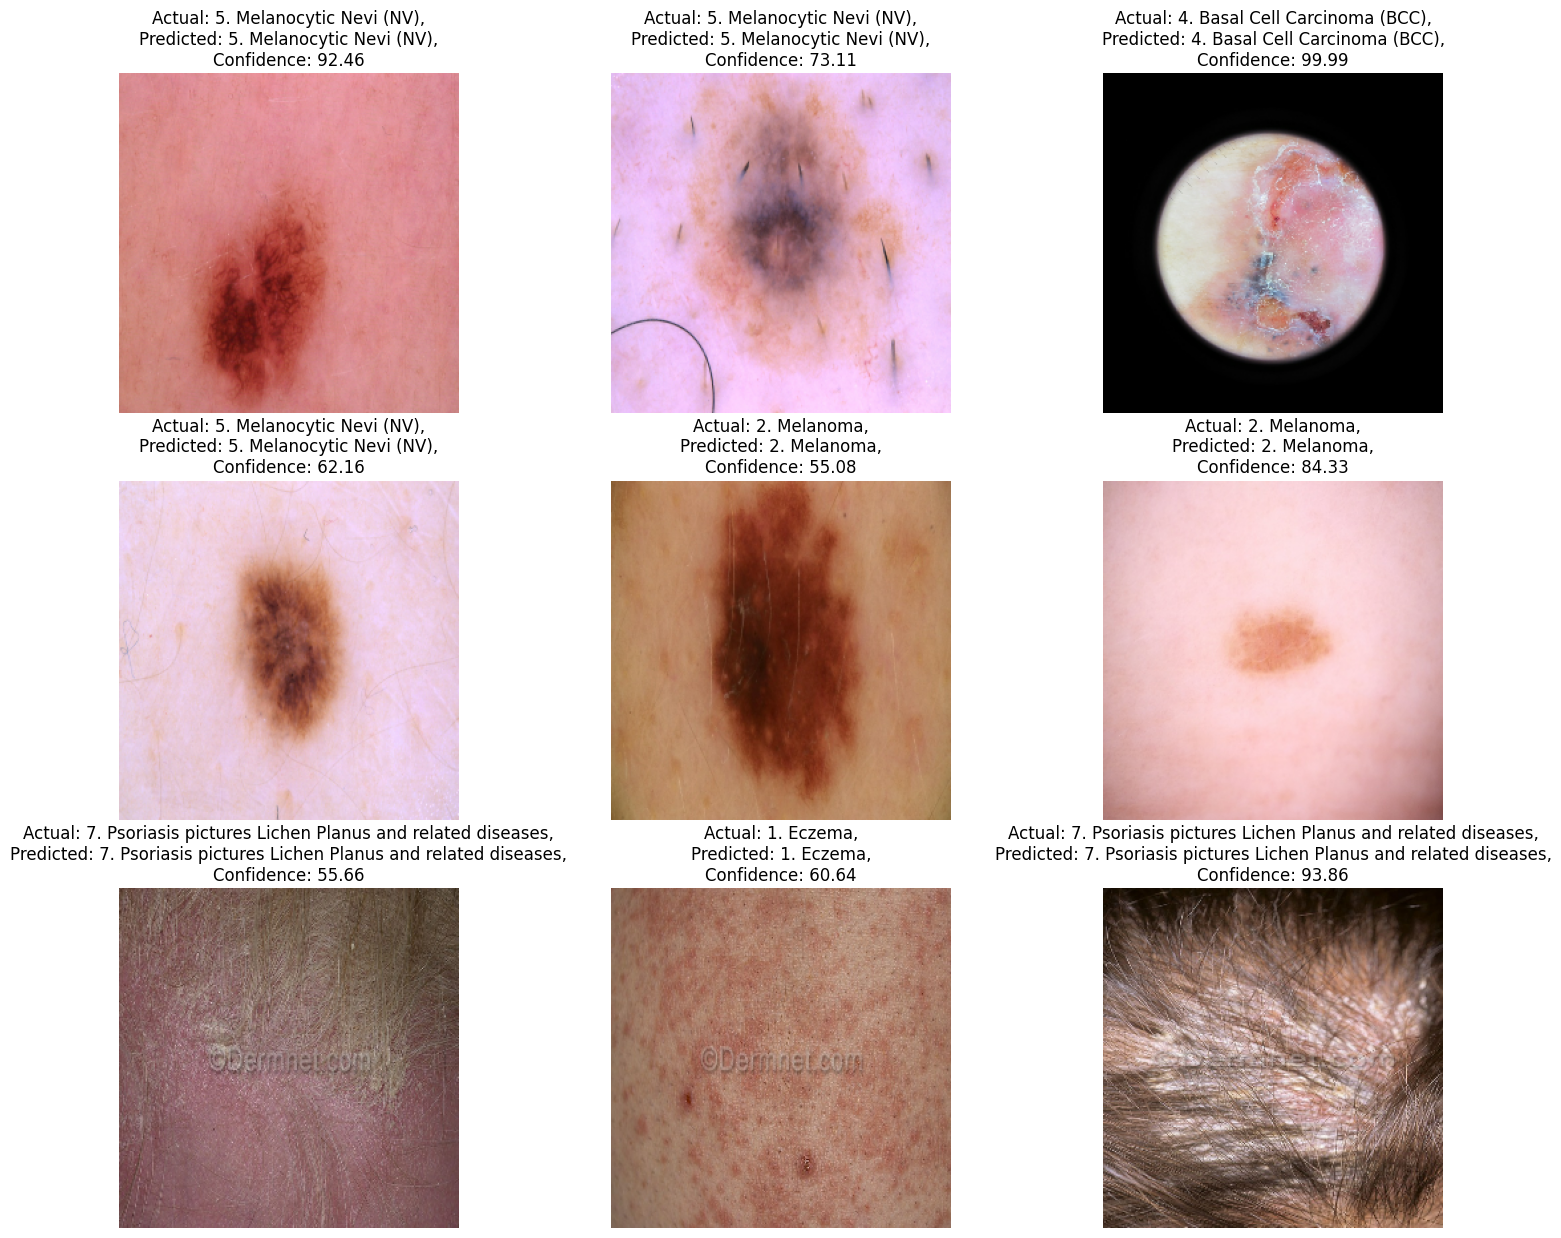

In [61]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming you have your `test_ds` and `model` defined
plt.figure(figsize=(18, 15))
for images, labels in test_ds.take(1):
    for i in range(9): 
        ax = plt.subplot(3, 3, i + 1)
        image = (images[i].numpy() * 255).astype('uint8')  # Convert the image to uint8
        plt.imshow(image)
        
        predicted_class, confidence = prediction(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}")
        plt.axis("off")
plt.show()


In [62]:
model.save('my_model_vgg16_v1.keras')